In [1]:
from datetime import timedelta
from functools import partial

import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import shapely as shp
from pymeos import *
from pymeos.plotters import *
from tqdm.auto import tqdm
import shapely.geometry as sg


ais = pd.read_csv("/Users/marianaduarte/MobilityDB/meos/examples/data/aisdk-2024-03-01_MMSI265041000.csv")
ais.head()
tqdm.pandas()

In [2]:
pymeos_initialize()

In [3]:
ais = ais[['MMSI', 'Timestamp', 'SOG', 'COG', 'Latitude', 'Longitude']].dropna()
ais['Timestamp'] = pd.to_datetime(ais['Timestamp'], format='%d/%m/%Y %H:%M:%S')
ais = ais[(ais['Latitude'] >= 40.18) & (ais['Latitude'] <= 84.73) &
          (ais['Longitude'] >= -16.1) & (ais['Longitude'] <= 32.88)]
ais = ais.drop_duplicates(['Timestamp', 'MMSI'])
ais['Geom'] = shp.points(ais['Longitude'], ais['Latitude'])
ais.head()

,MMSI,Timestamp,SOG,COG,Latitude,Longitude,Geom
0,265041000,2024-03-01 00:00:09,9.7,83.8,56.037317,12.645257,POINT (12.645257 56.037317)
1,265041000,2024-03-01 00:00:19,9.7,83.2,56.037360,12.646145,POINT (12.646145 56.03736)
2,265041000,2024-03-01 00:00:30,9.7,83.5,56.037423,12.647040,POINT (12.64704 56.037423)
3,265041000,2024-03-01 00:00:39,9.7,83.8,56.037480,12.647745,POINT (12.647745 56.03748)
4,265041000,2024-03-01 00:00:49,9.7,84.0,56.037527,12.648543,POINT (12.648543 56.037527)


In [4]:
ships = ais[['MMSI', 'Timestamp', 'SOG', 'COG', 'Geom']].copy()

In [5]:
from tqdm.auto import tqdm
tqdm.pandas(desc="Building temporal instances")

# If you meant to operate on `ships`, call on `ships`
ships['SOG'] = ships.progress_apply(lambda row: TFloatInst(value=row['SOG'], timestamp=row['Timestamp']), axis=1)
ships['COG'] = ships.progress_apply(lambda row: TFloatInst(value=row['COG'], timestamp=row['Timestamp']), axis=1)
ships['Geom'] = ships.progress_apply(
    lambda row: TGeomPointInst(point=row['Geom'], timestamp=row['Timestamp'], srid=25832), axis=1)

Building temporal instances:   0%|          | 0/9058 [00:00<?, ?it/s]

Building temporal instances:   0%|          | 0/9058 [00:00<?, ?it/s]

Building temporal instances:   0%|          | 0/9058 [00:00<?, ?it/s]

In [6]:
ships = ships.sort_values(by='Timestamp').groupby('MMSI').agg(list)
ships.head()

,Timestamp,SOG,COG,Geom
MMSI,,,,
265041000,"[2024-03-01 00:00:09, 2024-03-01 00:00:19, 202...","[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ...",[POINT(12.645257 56.037317)@2024-03-01 00:00:0...


In [7]:
ships['SOG'] = ships['SOG'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
ships['COG'] = ships['COG'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
ships['Trip'] = ships['Geom'].progress_apply(lambda x: TGeomPointSeq(instant_list=x, upper_inc=True).set_srid(4326))

Building temporal instances:   0%|          | 0/1 [00:00<?, ?it/s]

Building temporal instances:   0%|          | 0/1 [00:00<?, ?it/s]

Building temporal instances:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
s = ships.reset_index()[['MMSI', 'SOG', 'COG', 'Trip']].copy()
s['SOG'] = s['SOG'].apply(lambda x: x.as_hexwkb())
s['COG'] = s['COG'].apply(lambda x: x.as_hexwkb())
s['Trip'] = s['Trip'].apply(lambda x: x.as_hexwkb())
s.to_csv('ships.csv')

In [9]:
ships = pd.read_csv('ships.csv', converters={
    'SOG': TFloatSeq.from_hexwkb,
    'COG': TFloatSeq.from_hexwkb,
    'Trip': partial(TGeomPointSeq.from_hexwkb, srid=4326)
})

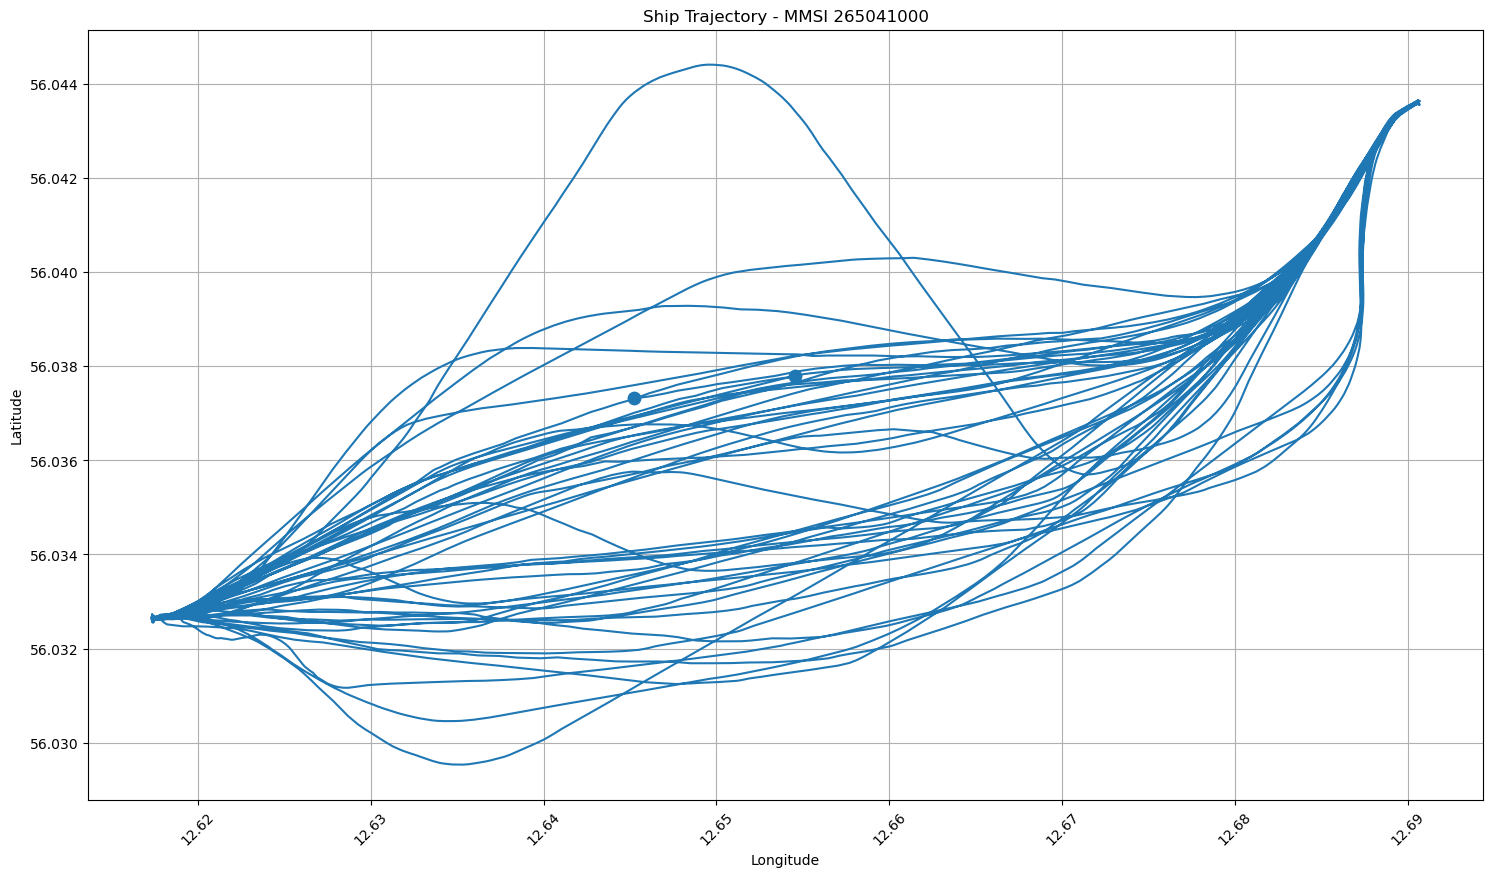

In [10]:
_, ax = plt.subplots(figsize=(18, 10))
_ = TemporalPointSequencePlotter.plot_sequences_xy(ships['Trip'], axes=ax, show_markers=True, show_grid=True)
ax.set_title('Ship Trajectory - MMSI 265041000')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [11]:
helsingor = shp.set_srid(shp.Point(12.616993, 56.033020), 4326)
helsingborg = shp.set_srid(shp.Point(12.685937, 56.042766), 4326)

helsingor_bb = STBox.from_geometry(helsingor).expand(0.005)
helsingborg_bb = STBox.from_geometry(helsingborg).expand(0.005)

joined = helsingor_bb.union(helsingborg_bb)

In [12]:
intersect_index = ships['Trip'].progress_apply(lambda trip: trip.ever_intersects(joined))
possible_ferries = ships[intersect_index]
non_ferries = ships[~intersect_index]

Building temporal instances:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
ferries_index = possible_ferries['Trip'].progress_apply(lambda trip: trip.ever_intersects(helsingor_bb)
                                                                     and trip.ever_intersects(helsingborg_bb))
ferries = possible_ferries[ferries_index]
non_ferries_intersect = possible_ferries[~ferries_index]

Building temporal instances:   0%|          | 0/1 [00:00<?, ?it/s]

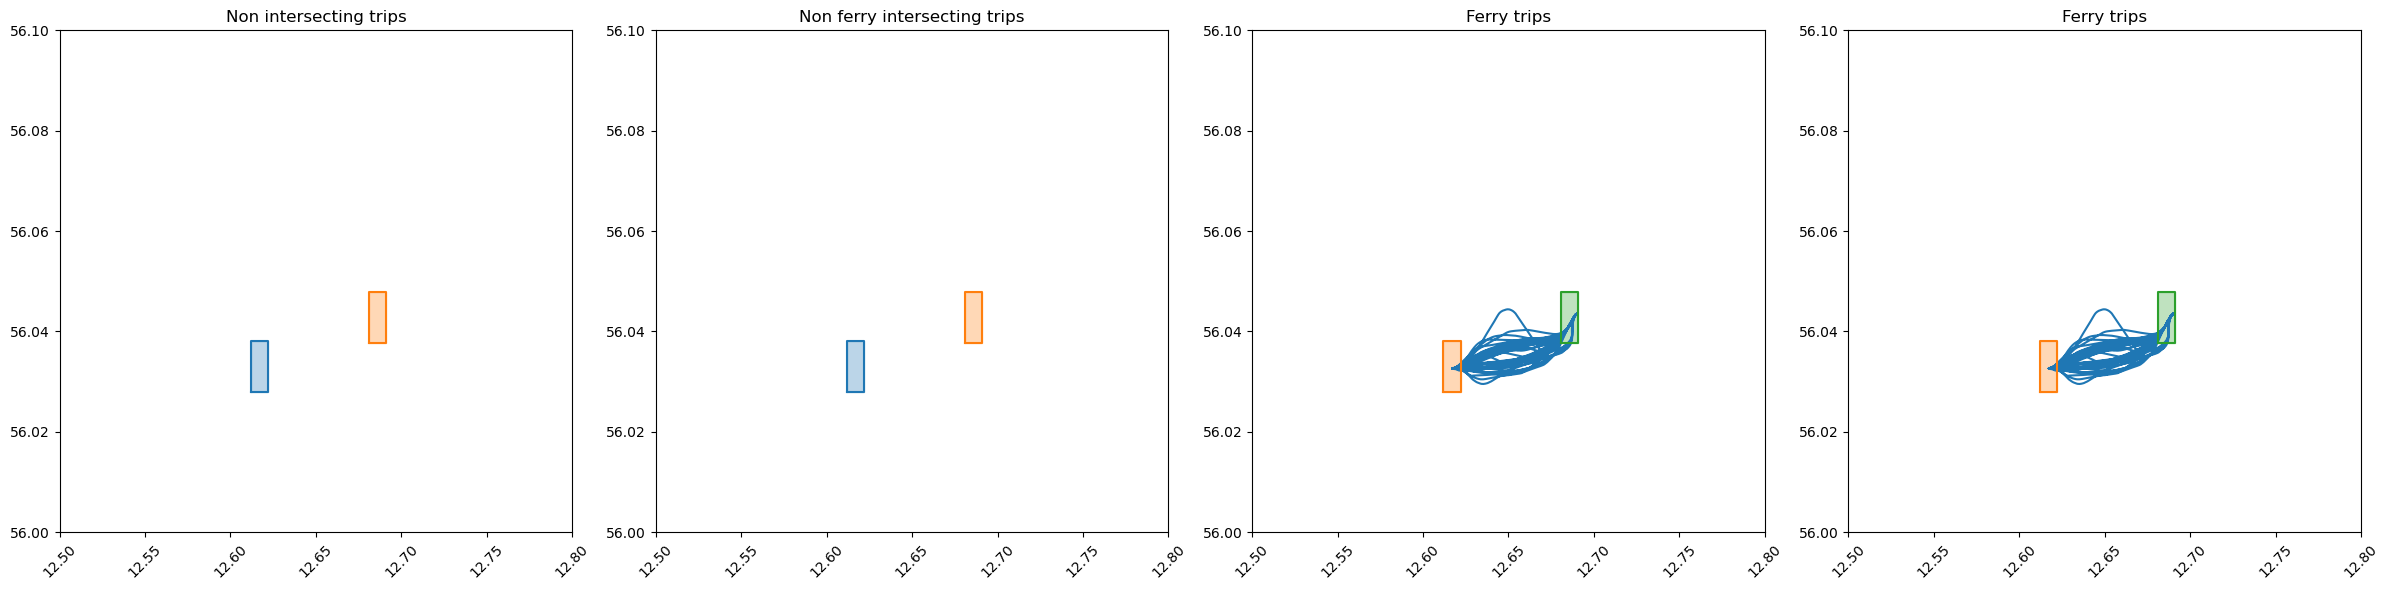

In [14]:
_, ax = plt.subplots(1, 4, figsize=(24, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(non_ferries['Trip'], axes=ax[0], show_markers=False, show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(non_ferries_intersect['Trip'], axes=ax[1], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(ferries['Trip'], axes=ax[2], show_markers=False, show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(ferries['Trip'], axes=ax[3], show_markers=False, show_grid=False)
ax[0].set_title('Non intersecting trips')
ax[1].set_title('Non ferry intersecting trips')
ax[2].set_title('Ferry trips')
ax[3].set_title('Ferry trips')
for i in range(4):
    _ = helsingor_bb.plot_xy(axes=ax[i])
    _ = helsingborg_bb.plot_xy(axes=ax[i])
    ax[i].set_xlim(12.5, 12.8)
    ax[i].set_ylim(56.0, 56.1)
plt.tight_layout()
plt.show()

In [15]:
f = ferries[['MMSI', 'SOG', 'COG', 'Trip']].copy()
f['SOG'] = f['SOG'].apply(lambda x: x.as_hexwkb())
f['COG'] = f['COG'].apply(lambda x: x.as_hexwkb())
f['Trip'] = f['Trip'].apply(lambda x: x.as_hexwkb())
f.to_csv('ferries.csv', index=False)

nf = pd.concat([
    non_ferries[['MMSI', 'SOG', 'COG', 'Trip']].copy(),
    non_ferries_intersect[['MMSI', 'SOG', 'COG', 'Trip']].copy(),
])
nf['SOG'] = nf['SOG'].apply(lambda x: x.as_hexwkb())
nf['COG'] = nf['COG'].apply(lambda x: x.as_hexwkb())
nf['Trip'] = nf['Trip'].apply(lambda x: x.as_hexwkb())
nf.to_csv('non_ferries.csv', index=False)

In [16]:
ferries = pd.read_csv('ferries.csv', converters={
    'SOG': TFloatSeq.from_hexwkb,
    'COG': TFloatSeq.from_hexwkb,
    'Trip': partial(TGeomPointSeq.from_hexwkb, srid=4326)
})
non_ferries = pd.read_csv('non_ferries.csv', converters={
    'SOG': TFloatSeq.from_hexwkb,
    'COG': TFloatSeq.from_hexwkb,
    'Trip': partial(TGeomPointSeq.from_hexwkb, srid=4326)
})

In [17]:
geometry_ferries = ferries.copy()
geometry_ferries['Time Outside'] = geometry_ferries['Trip'].apply(
    lambda trip: trip.is_spatially_contained_in(helsingor_bb).temporal_or(
        trip.is_spatially_contained_in(helsingborg_bb)).when_false())
geometry_ferries['Single Trips'] = geometry_ferries.apply(lambda row: row['Trip'].at(row['Time Outside']), axis=1)


In [18]:
geometry_ferries.head()

,MMSI,SOG,COG,Trip,Time Outside,Single Trips
0,265041000,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ...",[POINT(12.645257 56.037317)@2024-03-01 00:00:0...,"{[2024-03-01 00:00:09+01, 2024-03-01 00:07:44....",{[POINT(12.645257 56.037317)@2024-03-01 00:00:...


In [19]:
geometry_single_ferry_trips = geometry_ferries[['MMSI', 'Single Trips', 'SOG', 'COG']].copy()
geometry_single_ferry_trips['Single Trips'] = geometry_single_ferry_trips['Single Trips'].apply(
    lambda trip: trip.sequences())
geometry_single_ferry_trips = geometry_single_ferry_trips.explode('Single Trips').rename({'Single Trips': 'Trip'},
                                                                                         axis=1)
geometry_single_ferry_trips.insert(1, 'Trip #', geometry_single_ferry_trips.groupby('MMSI').cumcount() + 1)
geometry_single_ferry_trips.head()

,MMSI,Trip #,Trip,SOG,COG
0,265041000,1,[POINT(12.645257 56.037317)@2024-03-01 00:00:0...,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ..."
0,265041000,2,[POINT(12.680937000015199 56.038946049138005)@...,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ..."
0,265041000,3,(POINT(12.617403 56.032635)@2024-03-01 00:40:2...,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ..."
0,265041000,4,(POINT(12.617393 56.032608)@2024-03-01 00:54:0...,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ..."
0,265041000,5,[POINT(12.621992999968 56.03312892423866)@2024...,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ..."


In [20]:
geometry_single_ferry_trips['SOG'] = geometry_single_ferry_trips.apply(lambda row: row['SOG'].at(row
                                                                                                 ['Trip'].time()),
                                                                       axis=1)
geometry_single_ferry_trips['COG'] = geometry_single_ferry_trips.apply(lambda row: row['COG'].at(row['Trip'].time()),
                                                                       axis=1)
geometry_single_ferry_trips.head()

,MMSI,Trip #,Trip,SOG,COG
0,265041000,1,[POINT(12.645257 56.037317)@2024-03-01 00:00:0...,"{[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 0...","{[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01..."
0,265041000,2,[POINT(12.680937000015199 56.038946049138005)@...,"{[9.7@2024-03-01 00:25:25.736994+01, 9.7@2024-...","{[236.80115592@2024-03-01 00:25:25.736994+01, ..."
0,265041000,3,(POINT(12.617403 56.032635)@2024-03-01 00:40:2...,"{(0.2@2024-03-01 00:40:20+01, 0@2024-03-01 00:...","{(255.6@2024-03-01 00:40:20+01, 256.5@2024-03-..."
0,265041000,4,(POINT(12.617393 56.032608)@2024-03-01 00:54:0...,"{(0.1@2024-03-01 00:54:09+01, 0.1@2024-03-01 0...","{(226.5@2024-03-01 00:54:09+01, 226.5@2024-03-..."
0,265041000,5,[POINT(12.621992999968 56.03312892423866)@2024...,{[8.028787866666667@2024-03-01 01:02:31.295454...,{[78.27196966666666@2024-03-01 01:02:31.295454...


ERROR 1: PROJ: internal_proj_create_from_database: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


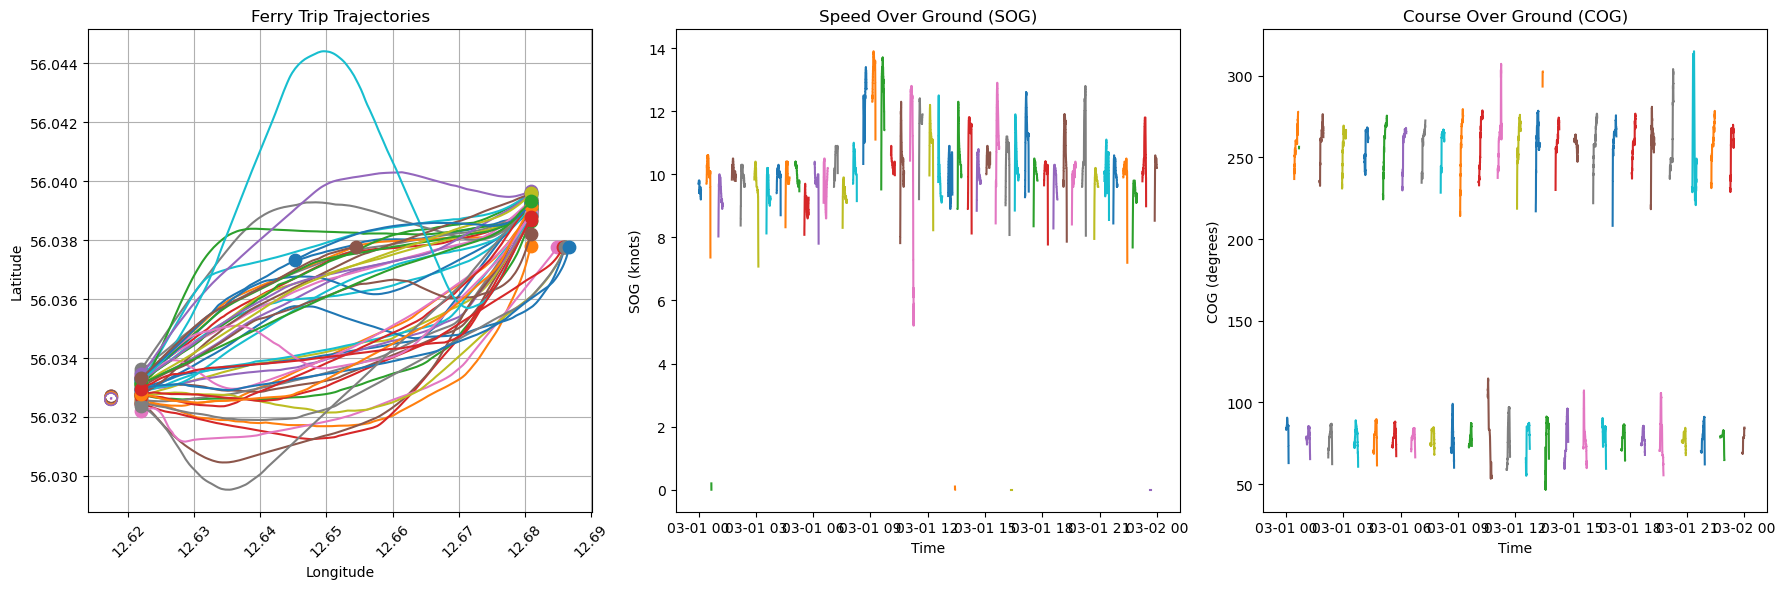

In [21]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot ferry trajectories with background map
_ = TemporalPointSequencePlotter.plot_sequences_xy(geometry_single_ferry_trips['Trip'], axes=ax[0])
ax[0].set_title('Ferry Trip Trajectories')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Add background map to the trajectory plot
try:
    cx.add_basemap(ax[0], crs='EPSG:4326', source=cx.providers.CartoDB.Positron, alpha=0.7)
except:
    pass  # Continue if basemap fails

# Plot SOG using the float plotter
for sog_seq in geometry_single_ferry_trips['SOG']:
    if hasattr(sog_seq, 'plot_time'):
        sog_seq.plot_time(axes=ax[1])
    else:
        # Fixed: Call the methods with parentheses
        times = [inst.timestamp() for inst in sog_seq.instants()]
        values = [inst.value() for inst in sog_seq.instants()]
        ax[1].plot(times, values)

ax[1].set_title('Speed Over Ground (SOG)')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('SOG (knots)')

# Plot COG using the float plotter
for cog_seq in geometry_single_ferry_trips['COG']:
    if hasattr(cog_seq, 'plot_time'):
        cog_seq.plot_time(axes=ax[2])
    else:
        # Fixed: Call the methods with parentheses
        times = [inst.timestamp() for inst in cog_seq.instants()]
        values = [inst.value() for inst in cog_seq.instants()]
        ax[2].plot(times, values)

ax[2].set_title('Course Over Ground (COG)')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('COG (degrees)')

plt.tight_layout()
plt.show()

In [22]:
stops_ferries = ferries.copy()
stops_ferries['Stops'] = stops_ferries['Trip'].apply(lambda trip: trip.stops(0.0025, timedelta(minutes=10)).time())
stops_ferries['Single Trips'] = stops_ferries.apply(lambda row: row['Trip'].minus(row['Stops']).sequences(), axis=1)
stops_ferries.head()

,MMSI,SOG,COG,Trip,Stops,Single Trips
0,265041000,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ...",[POINT(12.645257 56.037317)@2024-03-01 00:00:0...,"{[2024-03-01 00:12:20+01, 2024-03-01 00:23:03+...",[[POINT(12.645257 56.037317)@2024-03-01 00:00:...


In [23]:
stops_single_ferry_trips = stops_ferries[['MMSI', 'Single Trips', 'SOG', 'COG']].copy()
stops_single_ferry_trips = stops_single_ferry_trips.explode('Single Trips').rename({'Single Trips': 'Trip'}, axis=1)
stops_single_ferry_trips.insert(1, 'Trip #', stops_single_ferry_trips.groupby('MMSI').cumcount() + 1)
stops_single_ferry_trips.head()

,MMSI,Trip #,Trip,SOG,COG
0,265041000,1,[POINT(12.645257 56.037317)@2024-03-01 00:00:0...,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ..."
0,265041000,2,(POINT(12.688318 56.04282)@2024-03-01 00:23:03...,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ..."
0,265041000,3,(POINT(12.61974 56.032837)@2024-03-01 01:01:54...,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ..."
0,265041000,4,(POINT(12.688258 56.04273)@2024-03-01 01:42:23...,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ..."
0,265041000,5,(POINT(12.61951 56.032887)@2024-03-01 02:11:39...,"[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 00...","[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01 ..."


In [24]:
stops_single_ferry_trips['SOG'] = stops_single_ferry_trips.apply(lambda row: row['SOG'].at(row['Trip'].time()),
                                                                 axis=1)
stops_single_ferry_trips['COG'] = stops_single_ferry_trips.apply(lambda row: row['COG'].at(row['Trip'].time()),
                                                                 axis=1)
stops_single_ferry_trips.head()

,MMSI,Trip #,Trip,SOG,COG
0,265041000,1,[POINT(12.645257 56.037317)@2024-03-01 00:00:0...,"{[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 0...","{[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01..."
0,265041000,2,(POINT(12.688318 56.04282)@2024-03-01 00:23:03...,"{(6.5@2024-03-01 00:23:03+01, 6.7@2024-03-01 0...","{(226.2@2024-03-01 00:23:03+01, 227.9@2024-03-..."
0,265041000,3,(POINT(12.61974 56.032837)@2024-03-01 01:01:54...,"{(6.5@2024-03-01 01:01:54+01, 6.8@2024-03-01 0...","{(75.2@2024-03-01 01:01:54+01, 75.1@2024-03-01..."
0,265041000,4,(POINT(12.688258 56.04273)@2024-03-01 01:42:23...,"{(6.5@2024-03-01 01:42:23+01, 6.7@2024-03-01 0...","{(224.3@2024-03-01 01:42:23+01, 223.5@2024-03-..."
0,265041000,5,(POINT(12.61951 56.032887)@2024-03-01 02:11:39...,"{(6.5@2024-03-01 02:11:39+01, 7.1@2024-03-01 0...","{(68.7@2024-03-01 02:11:39+01, 65.4@2024-03-01..."


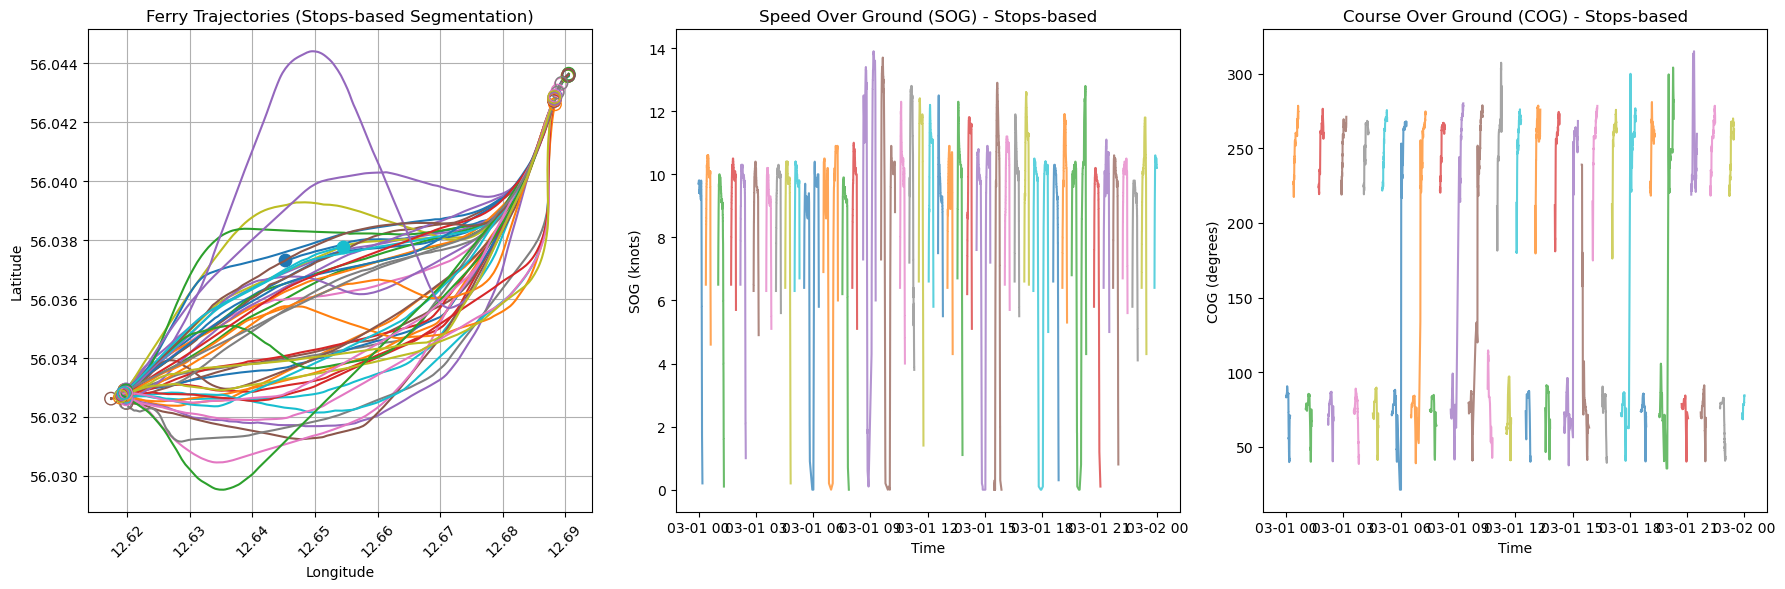

In [25]:
# Create visualization comparing geometry-based vs stops-based trip segmentation
_, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot trajectories
_ = TemporalPointSequencePlotter.plot_sequences_xy(stops_single_ferry_trips['Trip'], axes=ax[0])
ax[0].set_title('Ferry Trajectories (Stops-based Segmentation)')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Plot SOG over time for stops-based segmentation
for sog_seq in stops_single_ferry_trips['SOG']:
    times = [inst.timestamp() for inst in sog_seq.instants()]
    values = [inst.value() for inst in sog_seq.instants()]
    ax[1].plot(times, values, alpha=0.7)

ax[1].set_title('Speed Over Ground (SOG) - Stops-based')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('SOG (knots)')

# Plot COG over time for stops-based segmentation
for cog_seq in stops_single_ferry_trips['COG']:
    times = [inst.timestamp() for inst in cog_seq.instants()]
    values = [inst.value() for inst in cog_seq.instants()]
    ax[2].plot(times, values, alpha=0.7)

ax[2].set_title('Course Over Ground (COG) - Stops-based')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('COG (degrees)')

plt.tight_layout()
plt.show()

In [26]:
single_trips = stops_single_ferry_trips.copy()
ship_metrics = pd.DataFrame(index=single_trips['MMSI'].unique())

In [27]:
single_trips['Trip Distance'] = single_trips['Trip'].apply(lambda trip: trip.length())
total_distance = single_trips.groupby('MMSI')['Trip Distance'].sum()
ship_metrics = pd.concat([ship_metrics, total_distance], axis=1)
total_distance

MMSI
265041000    3.333239
Name: Trip Distance, dtype: float64

In [28]:
single_trips['Average Speed'] = single_trips['Trip'].apply(lambda trip: trip.speed().time_weighted_average())
single_trips['Average SOG'] = single_trips['SOG'].apply(lambda sog: sog.time_weighted_average())
single_trips

,MMSI,Trip #,Trip,SOG,COG,Trip Distance,Average Speed,Average SOG
0,265041000,1,[POINT(12.645257 56.037317)@2024-03-01 00:00:0...,"{[9.7@2024-03-01 00:00:09+01, 9.7@2024-03-01 0...","{[83.8@2024-03-01 00:00:09+01, 83.2@2024-03-01...",0.046412,0.000063,8.043981
0,265041000,2,(POINT(12.688318 56.04282)@2024-03-01 00:23:03...,"{(6.5@2024-03-01 00:23:03+01, 6.7@2024-03-01 0...","{(226.2@2024-03-01 00:23:03+01, 227.9@2024-03-...",0.070409,0.000077,9.674155
0,265041000,3,(POINT(12.61974 56.032837)@2024-03-01 01:01:54...,"{(6.5@2024-03-01 01:01:54+01, 6.8@2024-03-01 0...","{(75.2@2024-03-01 01:01:54+01, 75.1@2024-03-01...",0.072248,0.000067,8.440186
0,265041000,4,(POINT(12.688258 56.04273)@2024-03-01 01:42:23...,"{(6.5@2024-03-01 01:42:23+01, 6.7@2024-03-01 0...","{(224.3@2024-03-01 01:42:23+01, 223.5@2024-03-...",0.070648,0.000077,9.764885
0,265041000,5,(POINT(12.61951 56.032887)@2024-03-01 02:11:39...,"{(6.5@2024-03-01 02:11:39+01, 7.1@2024-03-01 0...","{(68.7@2024-03-01 02:11:39+01, 65.4@2024-03-01...",0.072374,0.000072,8.992525
0,265041000,6,(POINT(12.68828 56.042857)@2024-03-01 02:53:04...,"{(6.3@2024-03-01 02:53:04+01, 6.5@2024-03-01 0...","{(228.3@2024-03-01 02:53:04+01, 227.7@2024-03-...",0.070666,0.000074,9.332218
0,265041000,7,(POINT(12.619703 56.03282)@2024-03-01 03:32:49...,"{(6.3@2024-03-01 03:32:49+01, 7.1@2024-03-01 0...","{(74.1@2024-03-01 03:32:49+01, 72.9@2024-03-01...",0.070528,0.000073,9.185389
0,265041000,8,(POINT(12.688463 56.042855)@2024-03-01 04:03:2...,"{(6.3@2024-03-01 04:03:24+01, 6.5@2024-03-01 0...","{(224.8@2024-03-01 04:03:24+01, 224.2@2024-03-...",0.070649,0.000076,9.626404
0,265041000,9,(POINT(12.619428 56.032833)@2024-03-01 04:32:3...,"{(6.4@2024-03-01 04:32:30+01, 6.9@2024-03-01 0...","{(72.4@2024-03-01 04:32:30+01, 71.3@2024-03-01...",0.072641,0.000071,8.973873
0,265041000,10,(POINT(12.688347 56.042788)@2024-03-01 05:01:5...,"{(6.3@2024-03-01 05:01:53+01, 6.6@2024-03-01 0...","{(221.8@2024-03-01 05:01:53+01, 221.7@2024-03-...",0.070506,0.000076,9.690335


In [29]:
average_sog = single_trips.groupby('MMSI')['Average SOG'].mean()
ship_metrics = pd.concat([ship_metrics, average_sog], axis=1)
average_sog

MMSI
265041000    9.054048
Name: Average SOG, dtype: float64

In [30]:
ship_metrics

,Trip Distance,Average SOG
265041000,3.333239,9.054048


In [31]:
# Save single trips data to CSV files
stops_single_ferry_trips_csv = stops_single_ferry_trips.copy()
stops_single_ferry_trips_csv['Trip'] = stops_single_ferry_trips_csv['Trip'].apply(lambda x: x.as_hexwkb())
stops_single_ferry_trips_csv['SOG'] = stops_single_ferry_trips_csv['SOG'].apply(lambda x: x.as_hexwkb())
stops_single_ferry_trips_csv['COG'] = stops_single_ferry_trips_csv['COG'].apply(lambda x: x.as_hexwkb())
stops_single_ferry_trips_csv.to_csv('stops_single_ferry_trips.csv', index=False)

geometry_single_ferry_trips_csv = geometry_single_ferry_trips.copy()
geometry_single_ferry_trips_csv['Trip'] = geometry_single_ferry_trips_csv['Trip'].apply(lambda x: x.as_hexwkb())
geometry_single_ferry_trips_csv['SOG'] = geometry_single_ferry_trips_csv['SOG'].apply(lambda x: x.as_hexwkb())
geometry_single_ferry_trips_csv['COG'] = geometry_single_ferry_trips_csv['COG'].apply(lambda x: x.as_hexwkb())
geometry_single_ferry_trips_csv.to_csv('geometry_single_ferry_trips.csv', index=False)

print("Saved stops_single_ferry_trips.csv and geometry_single_ferry_trips.csv")

Saved stops_single_ferry_trips.csv and geometry_single_ferry_trips.csv


In [32]:
stops_trips_with_linestrings = stops_single_ferry_trips.copy()

# Extract coordinates from each trip and create LineString
stops_trips_with_linestrings['LineString'] = stops_trips_with_linestrings['Trip'].apply(
    lambda trip: sg.LineString([(point.x, point.y) for point in trip.values()])
)

# Display the first few entries
stops_trips_with_linestrings[['MMSI', 'Trip #', 'LineString']].head()
# Save trips with LineString geometries to CSV
trips_linestring_csv = stops_trips_with_linestrings.copy()
trips_linestring_csv['Trip'] = trips_linestring_csv['Trip'].apply(lambda x: x.as_hexwkb())
trips_linestring_csv['SOG'] = trips_linestring_csv['SOG'].apply(lambda x: x.as_hexwkb())
trips_linestring_csv['COG'] = trips_linestring_csv['COG'].apply(lambda x: x.as_hexwkb())
trips_linestring_csv['LineString'] = trips_linestring_csv['LineString'].apply(lambda x: x.wkt)
trips_linestring_csv.to_csv('stops_trips_with_linestrings.csv', index=False)

print("Saved stops_trips_with_linestrings.csv")

Saved stops_trips_with_linestrings.csv


In [36]:
geometry_trips_with_linestrings = geometry_single_ferry_trips.copy()

# Extract coordinates from each trip and create LineString
geometry_trips_with_linestrings['LineString'] = geometry_trips_with_linestrings['Trip'].apply(
    lambda trip: sg.LineString([(point.x, point.y) for point in trip.values()])
)

# Display the first few entries
geometry_trips_with_linestrings[['MMSI', 'Trip #', 'LineString']].head()

# Save trips with LineString geometries to CSV
geometry_trips_linestring_csv = geometry_trips_with_linestrings.copy()
geometry_trips_linestring_csv['Trip'] = geometry_trips_linestring_csv['Trip'].apply(lambda x: x.as_hexwkb())
geometry_trips_linestring_csv['SOG'] = geometry_trips_linestring_csv['SOG'].apply(lambda x: x.as_hexwkb())
geometry_trips_linestring_csv['COG'] = geometry_trips_linestring_csv['COG'].apply(lambda x: x.as_hexwkb())
geometry_trips_linestring_csv['LineString'] = geometry_trips_linestring_csv['LineString'].apply(lambda x: x.wkt)
geometry_trips_linestring_csv.to_csv('geometry_trips_with_linestrings.csv', index=False)

print("Saved geometry_trips_with_linestrings.csv")

Saved geometry_trips_with_linestrings.csv


In [ ]:
pymeos_finalize()